In [ ]:

import warnings

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from utils.dl_helper_functions import (load_picture_lagged_data)

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

# Display all columns in pandas
pd.options.display.max_columns = None

# Define global constants
DTYPE_NUMPY = np.float32              # Datentyp für numpy Arrays
n_jobs = -1                           # Anzahl CPUs für parallele Prozesse

plt.rcParams.update({
    "font.size": 18,                # Grundschriftgröße (wirkt auf alles, sofern nicht überschrieben)
    "axes.titlesize": 18,           # Größe des Titels der Achse (z.B. 'Subplot Title')
    "axes.labelsize": 18,           # Achsenbeschriftung (x/y label)
    "xtick.labelsize": 18,          # X-Tick-Beschriftung
    "ytick.labelsize": 18,          # Y-Tick-Beschriftung
    "legend.fontsize": 18,          # Legendentext
    "figure.titlesize": 18,         # Gesamttitel der Abbildung (plt.suptitle)
    "figure.labelsize": 18,         # (optional, selten verwendet)
    "savefig.dpi": 300,             # DPI beim Speichern
    "figure.dpi": 72,              # DPI bei Anzeige
})


In [2]:
# Load data
X, y_lagged, y, common_time = load_picture_lagged_data(
    return_common_time=True,
    verbose=False,
    grid_size=25,
    n_jobs=n_jobs,
    dtype=DTYPE_NUMPY,
    pca=False,
    keep_ocean_data=True,
    eda=True,
    land_values=0.0,  # Set land values to 0.0 for plotting purposes
)



Dropping columns: ['snowfall', 'siconc', 'rain', 'sithick', 'precipitation', 'weather_code', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_high', 'cloud_cover_mid', 'vapour_pressure_deficit', 'et0_fao_evapotranspiration', 'relative_humidity_2m', 'temperature_2m', 'dew_point_2m', 'apparent_temperature', 'mlotst']

Shapes of DataFrames after dropping columns:
Ocean DataFrame: (9415187, 14)
Weather DataFrame: (2018400, 22)
Insitu DataFrame: (20161, 2)


Interpolating wo: 100%|██████████| 20161/20161 [00:02<00:00, 7732.76it/s]


In [3]:
X

<xarray.Dataset> Size: 3GB
Dimensions:                     (time: 20137, latitude: 25, longitude: 25)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-04 ... 20...
  * latitude                    (latitude) float64 200B 53.72 53.99 ... 60.01
  * longitude                   (longitude) float64 200B 9.097 9.676 ... 22.99
Data variables: (12/30)
    bottomT                     (time, latitude, longitude) float64 101MB 0.0...
    mlotst                      (time, latitude, longitude) float64 101MB 0.0...
    siconc                      (time, latitude, longitude) float64 101MB 0.0...
    sithick                     (time, latitude, longitude) float64 101MB 0.0...
    sla                         (time, latitude, longitude) float64 101MB 0.0...
    so                          (time, latitude, longitude) float64 101MB 0.0...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 101MB 0.0...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 101MB 0.0...
    vapour_pressure_deficit     (time, latitude, longitude) float64 101MB 0.0...
    wind_gusts_10m              (time, latitude, longitude) float64 101MB 0.0...
    wind_u                      (time, latitude, longitude) float64 101MB 0.0...
    wind_v                      (time, latitude, longitude) float64 101MB 0.0...

In [ ]:
from utils.config import (
    LAT_FLENSBURG,
    LON_FLENSBURG,
    SUB_BOX,
    OCEAN_DICT,
    WEATHER_DICT,
    INSITU_DICT,
    OCEAN_POINTS,
    WEATHER_POINTS,
    )

SUB_BOX

{'lat_min': 54.0, 'lat_max': 55.5, 'lon_min': 9.2, 'lon_max': 13.0}

In [ ]:
# Filter data within tthe sub box
subset = X.sel(latitude=slice(SUB_BOX['lat_min'], SUB_BOX['lat_max']),
               longitude=slice(SUB_BOX['lon_min'], SUB_BOX['lon_max'])
               )

# all values which are higher than 9000 are set to NaN
subset = subset.where(subset < 9000)

# calculate mean over 'latitude' and 'longitude'
mean_values = subset.mean(dim=['latitude', 'longitude'])


mean_values

<xarray.Dataset> Size: 5MB
Dimensions:                     (time: 20137)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-04 ... 20...
Data variables: (12/30)
    bottomT                     (time) float64 161kB 6.166 6.156 ... 3.7 3.679
    mlotst                      (time) float64 161kB 7.922 7.807 ... 8.162 8.446
    siconc                      (time) float64 161kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sithick                     (time) float64 161kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    sla                         (time) float64 161kB -0.1021 ... 0.001203
    so                          (time) float64 161kB 9.66 9.67 ... 9.061 9.088
    ...                          ...
    cloud_cover_high            (time) float64 161kB 0.2453 0.06132 ... 0.0 0.0
    et0_fao_evapotranspiration  (time) float64 161kB 0.006776 ... 0.0226
    vapour_pressure_deficit     (time) float64 161kB 0.09611 0.09378 ... 0.1629
    wind_gusts_10m              (time) float64 161kB 29.48 29.89 ... 44.21 44.24
    wind_u                      (time) float64 161kB 16.7 15.87 ... 25.3 24.79
    wind_v                      (time) float64 161kB -0.9117 -0.5333 ... -2.959

In [6]:
y

<xarray.DataArray 'y' (time: 20137)> Size: 81kB
array([0.34479868, 0.2854355 , 0.21297951, ..., 0.53833336, 0.55      ,
       0.55      ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 161kB 2022-12-04 ... 2025-03-22

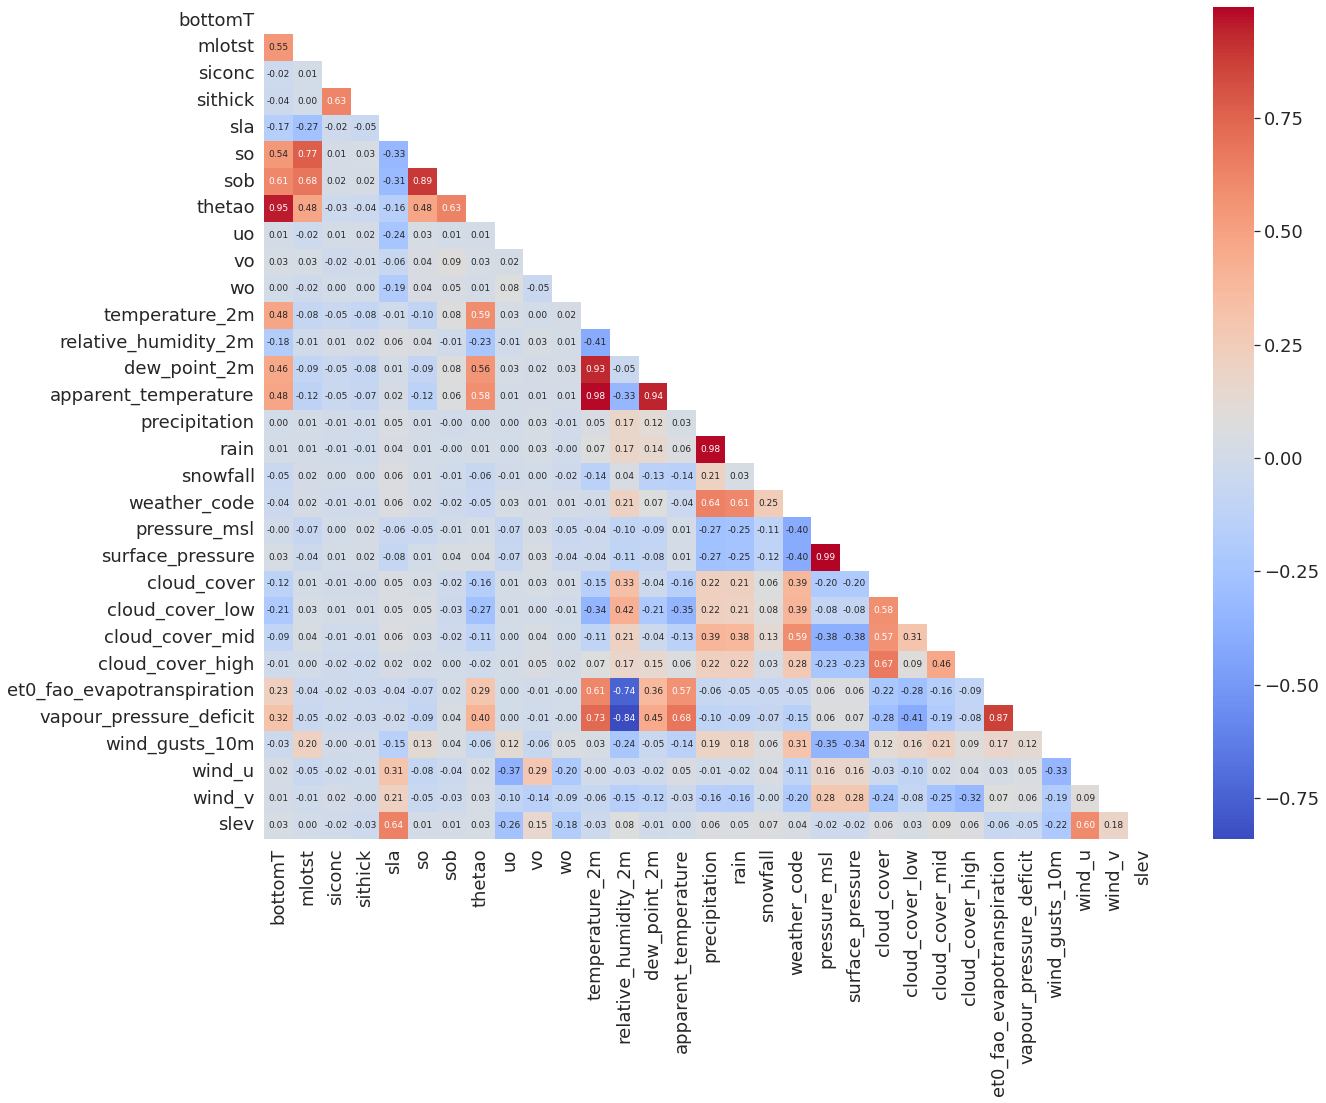

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

sturm_surge_list = [datetime.datetime(2023, 2, 25, 17, 0),
                    datetime.datetime(2023, 4, 1, 12, 0),
                    datetime.datetime(2023, 10, 7, 20, 0),
                    datetime.datetime(2023, 10, 20, 0, 0),
                    datetime.datetime(2024, 1, 3, 9, 0),
                    datetime.datetime(2024, 2, 9, 18, 0),
                    datetime.datetime(2024, 12, 9, 16, 0),
                    ]

# Konvertiere das xarray.Dataset in ein pandas.DataFrame
df_features = subset.to_dataframe().reset_index()




# Konvertiere y in ein pandas.Series
df_y = y.to_dataframe(name='y').reset_index()
df_y.rename(columns={'y': 'slev'}, inplace=True)
# Merge die Features und das Ziel (y) basierend auf der Zeit
df = pd.merge(df_features, df_y, on='time')
drop_cols = ['latitude', 'longitude', 'time'] 
df = df.drop(columns=drop_cols)
# Berechne die Korrelationsmatrix
correlation_matrix = df.corr()

# Plotten der Korrelationsmatrix
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            cbar=True, 
            mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
            square=False,
            annot_kws={"size": 9}  # Schriftgröße der Annotationen
            )
            # rotate the x-axis labels
plt.xticks(rotation=90)
plt.yticks(rotation=0)
#plt.title("Correlation over whole period")
plt.savefig("../thesis_plots/correlation_over_whole_period.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
dd

NameError: name 'dd' is not defined

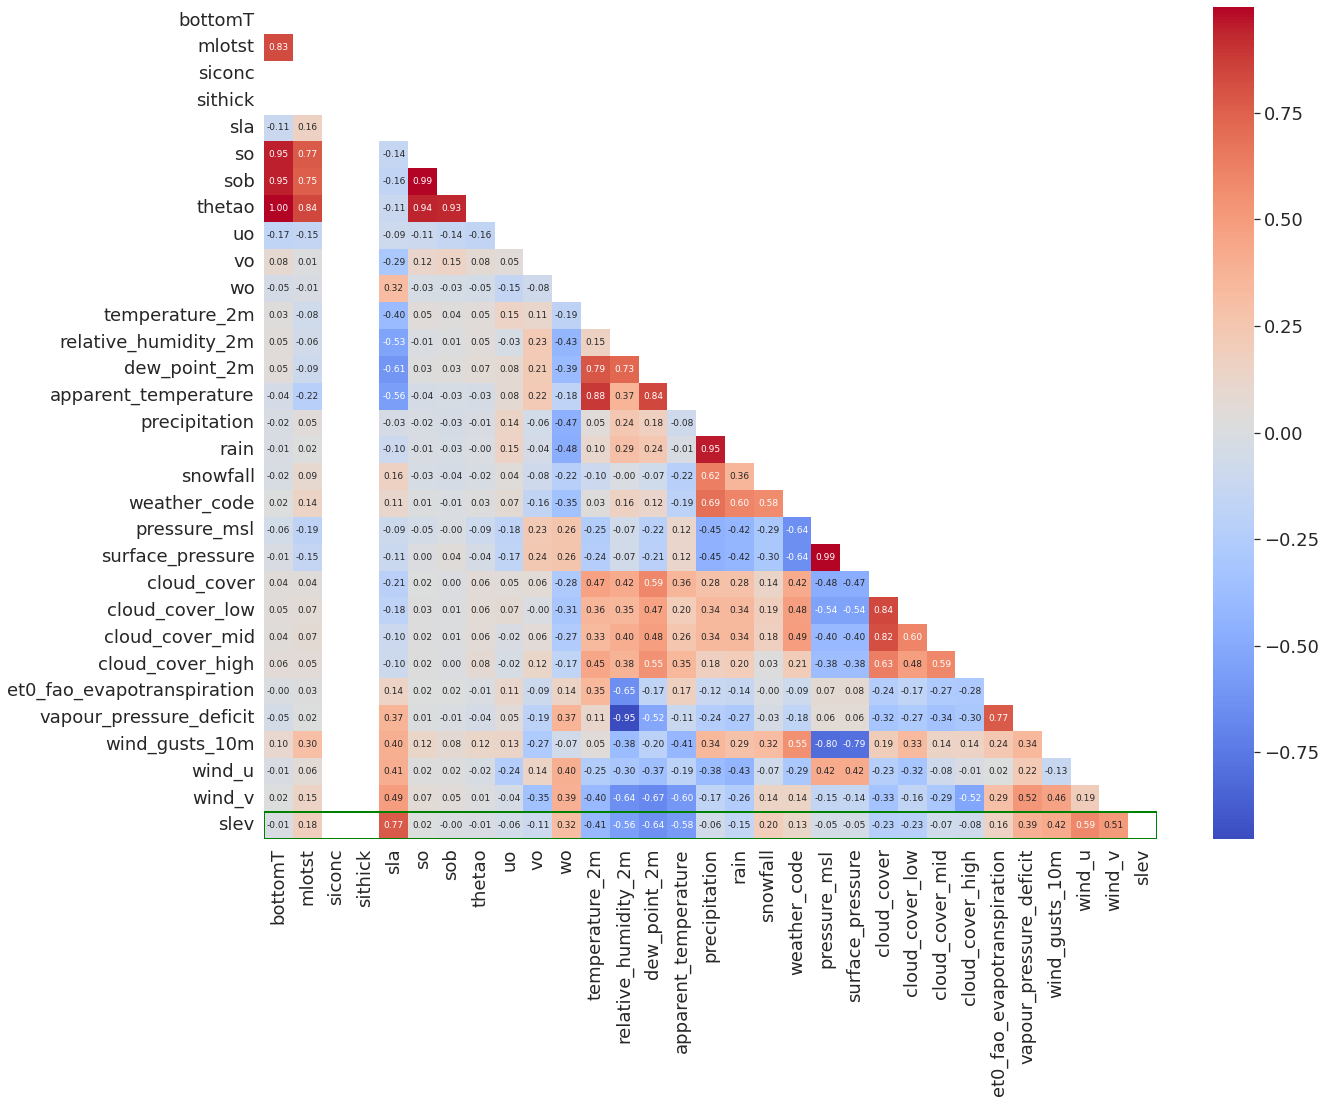

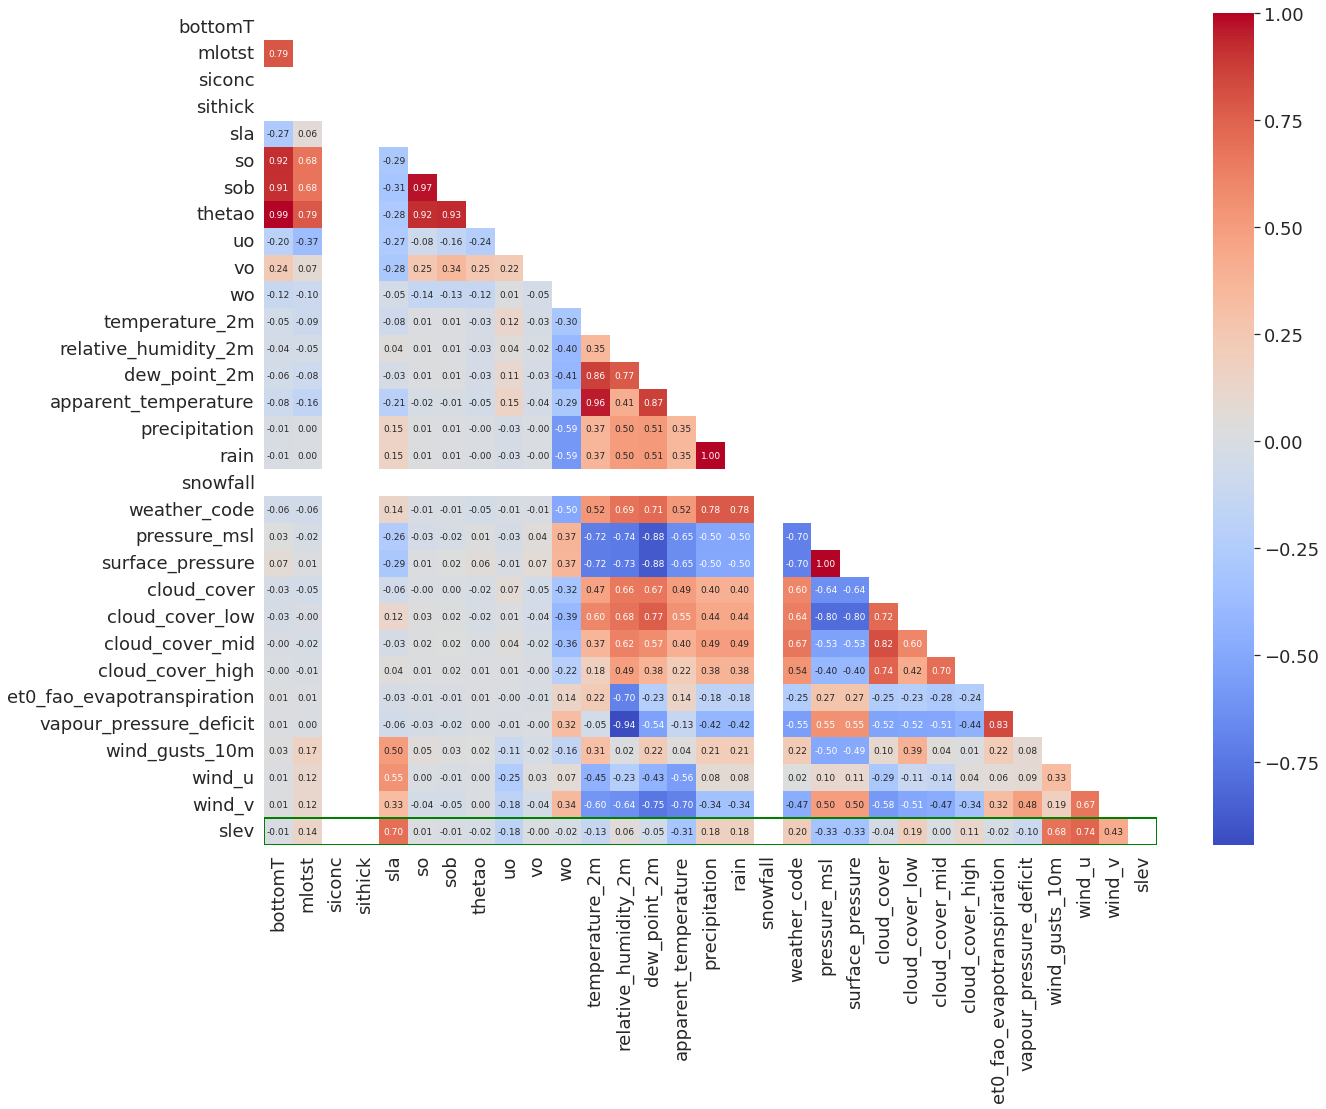

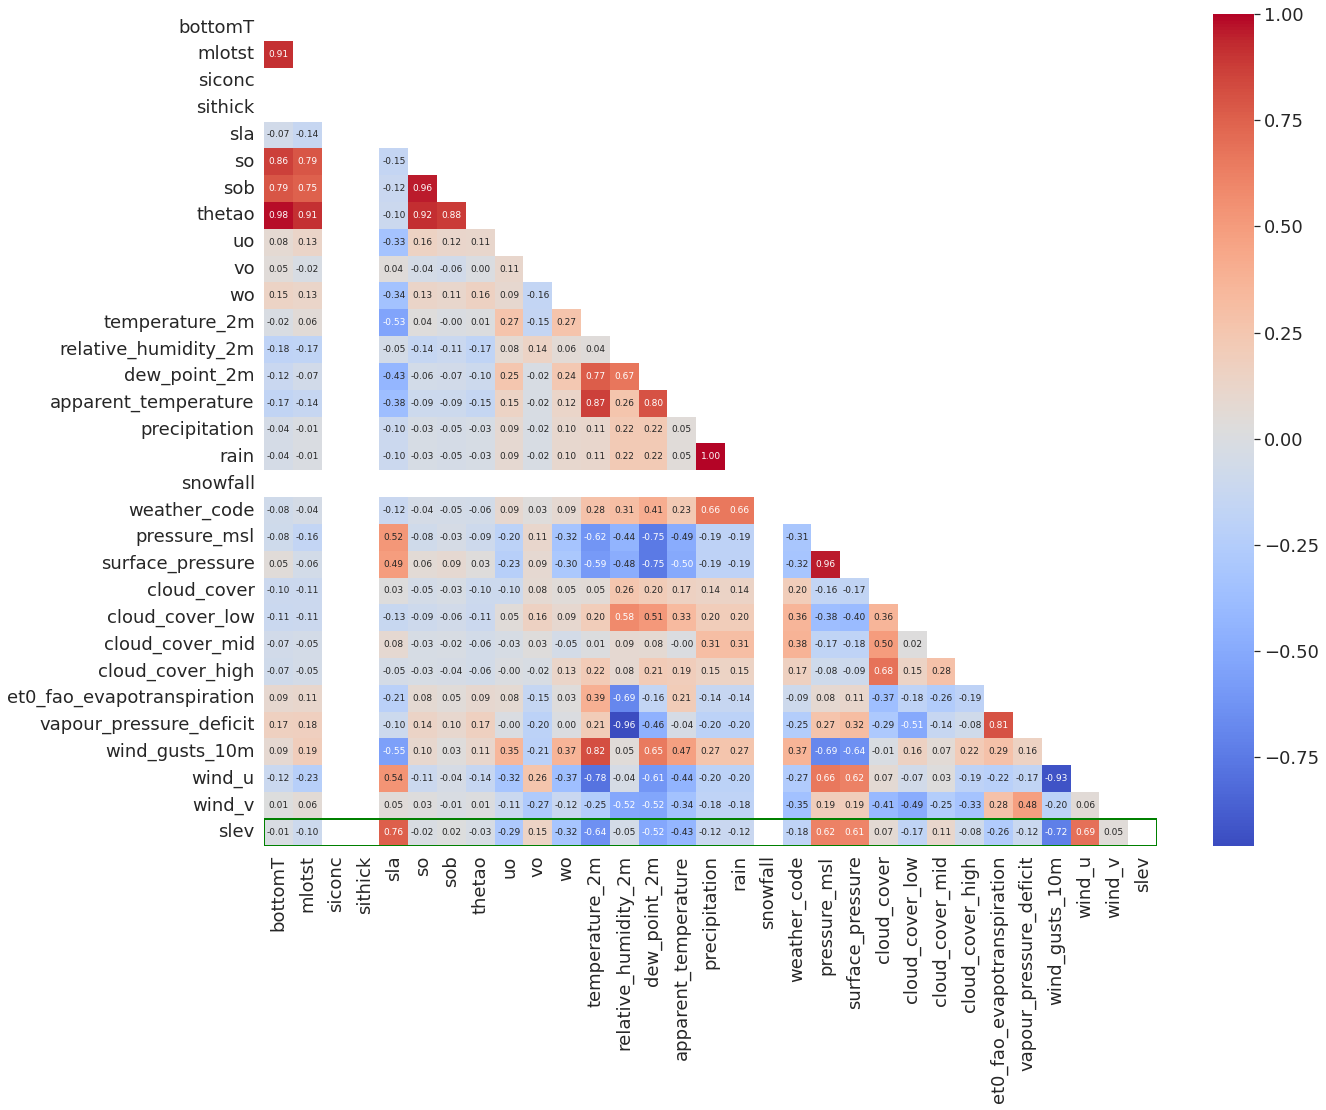

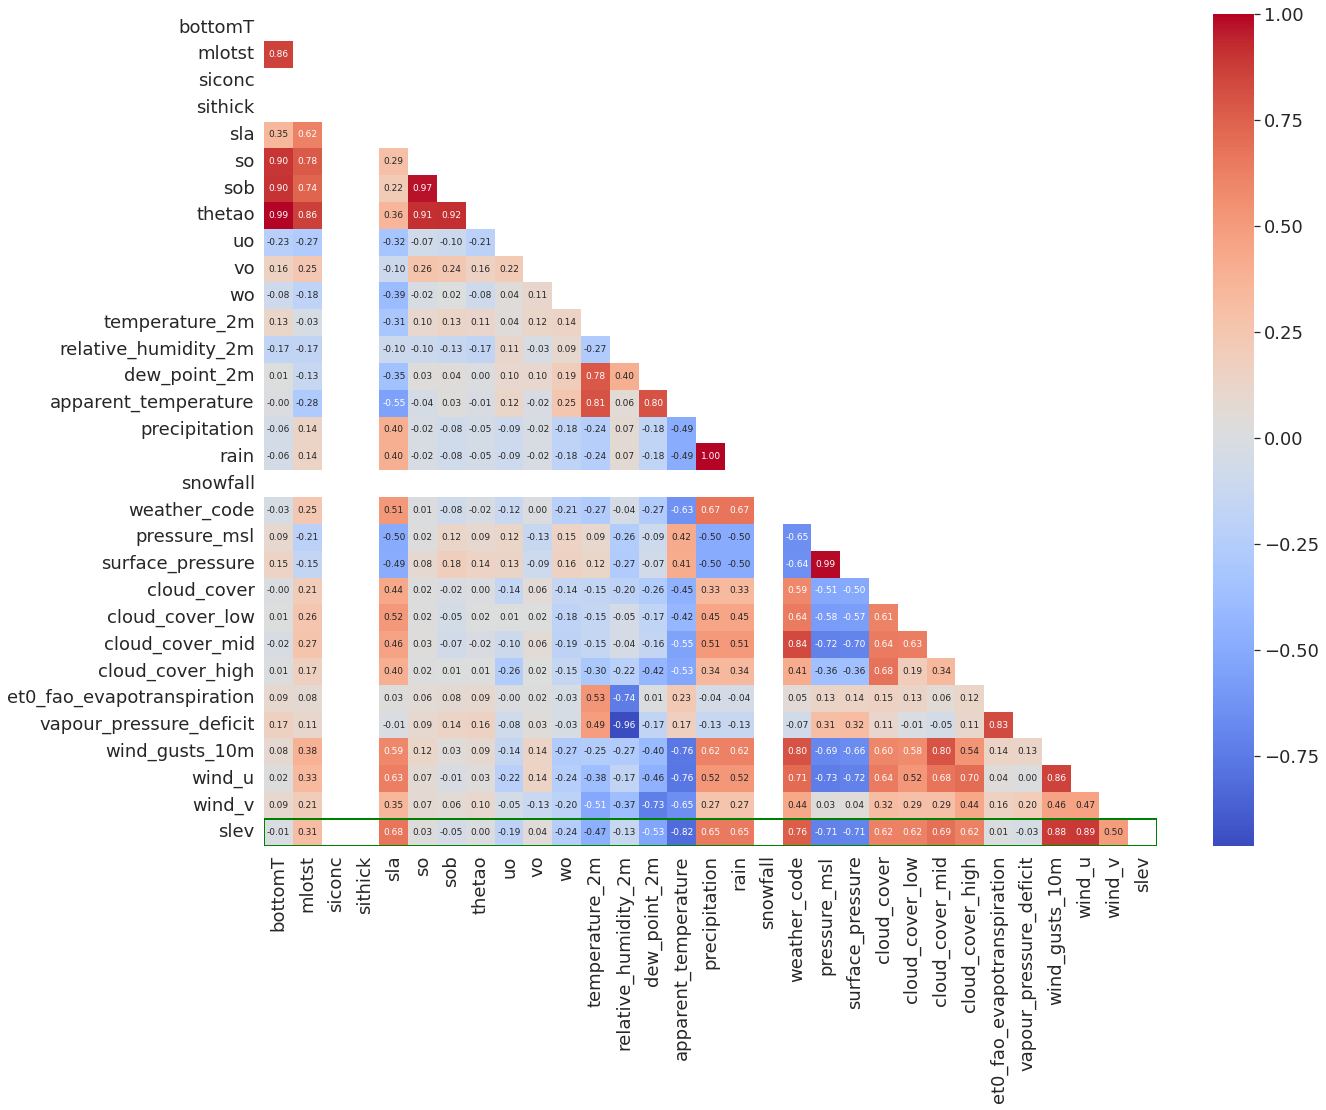

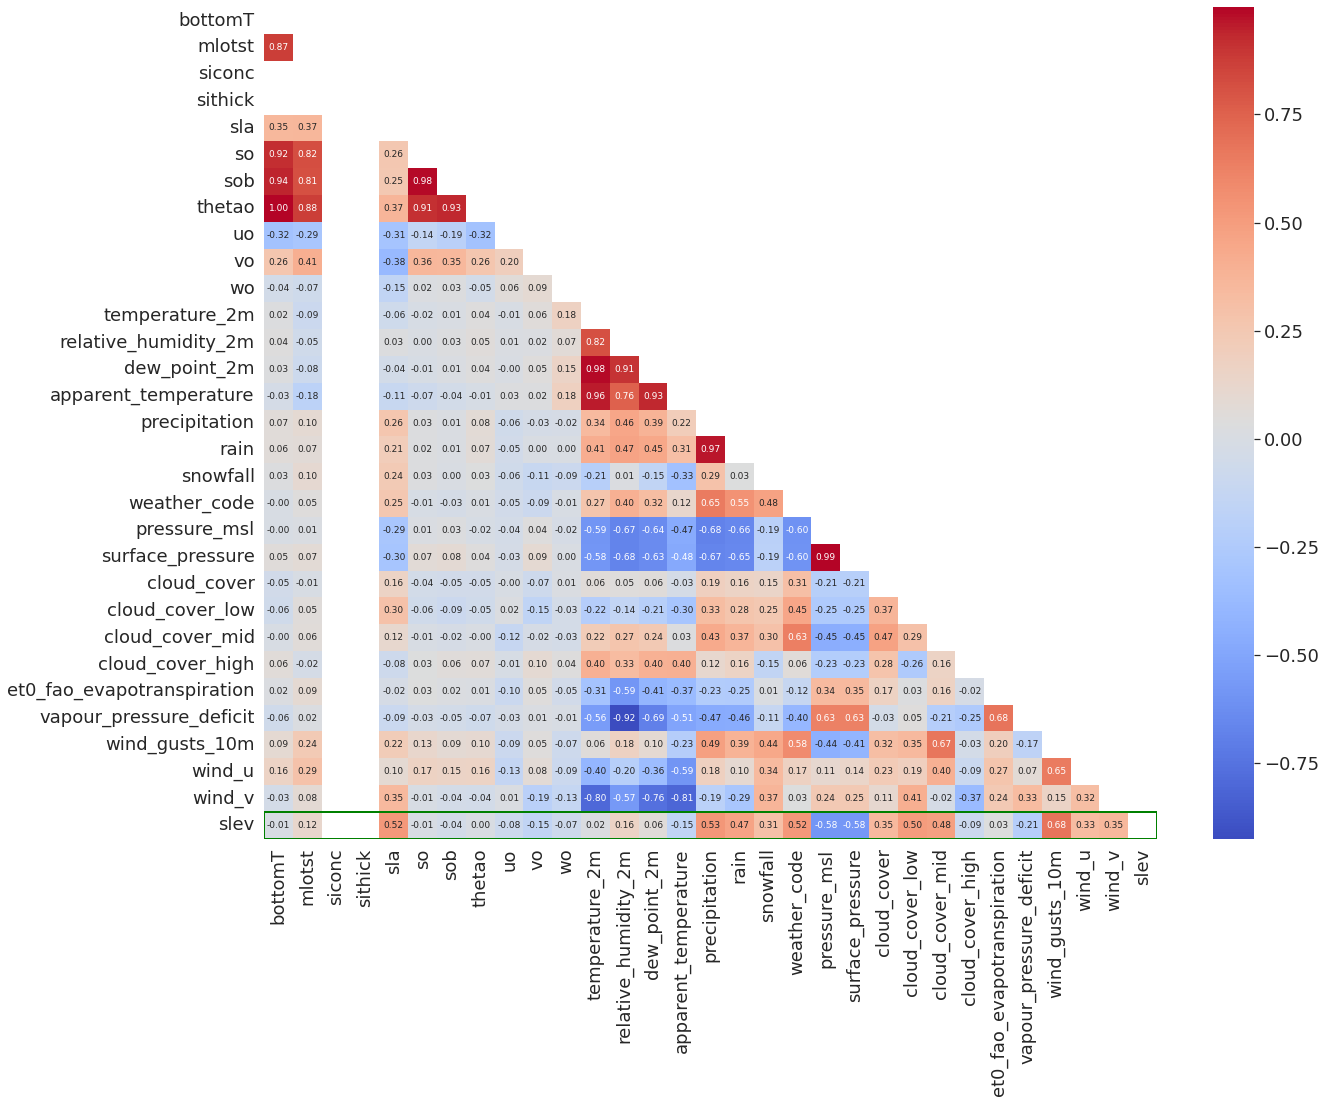

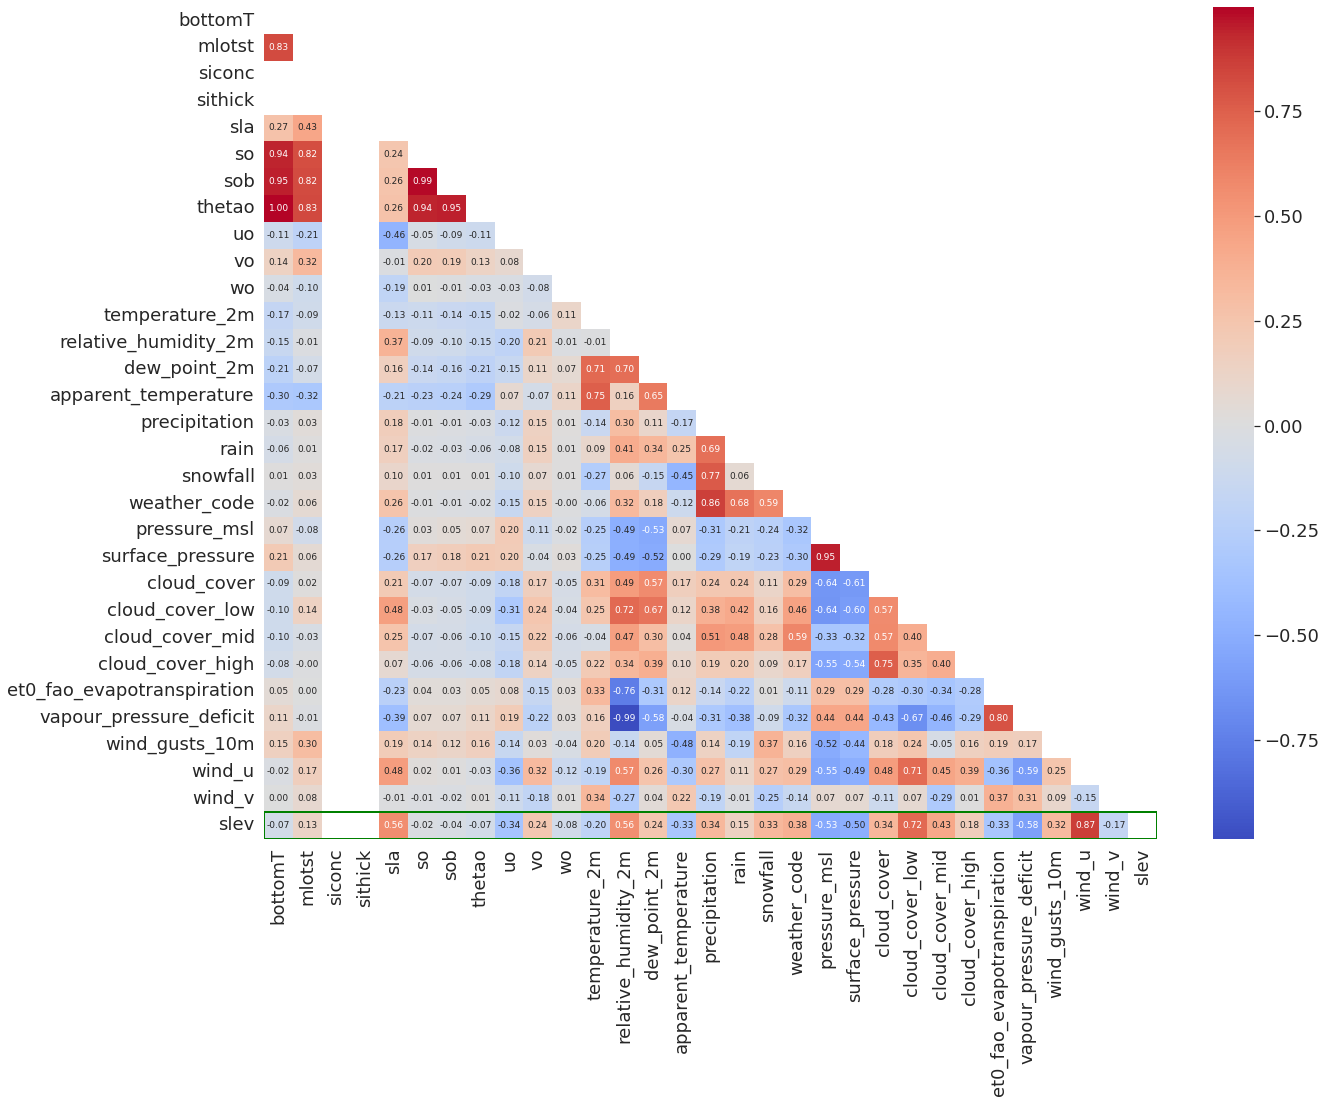

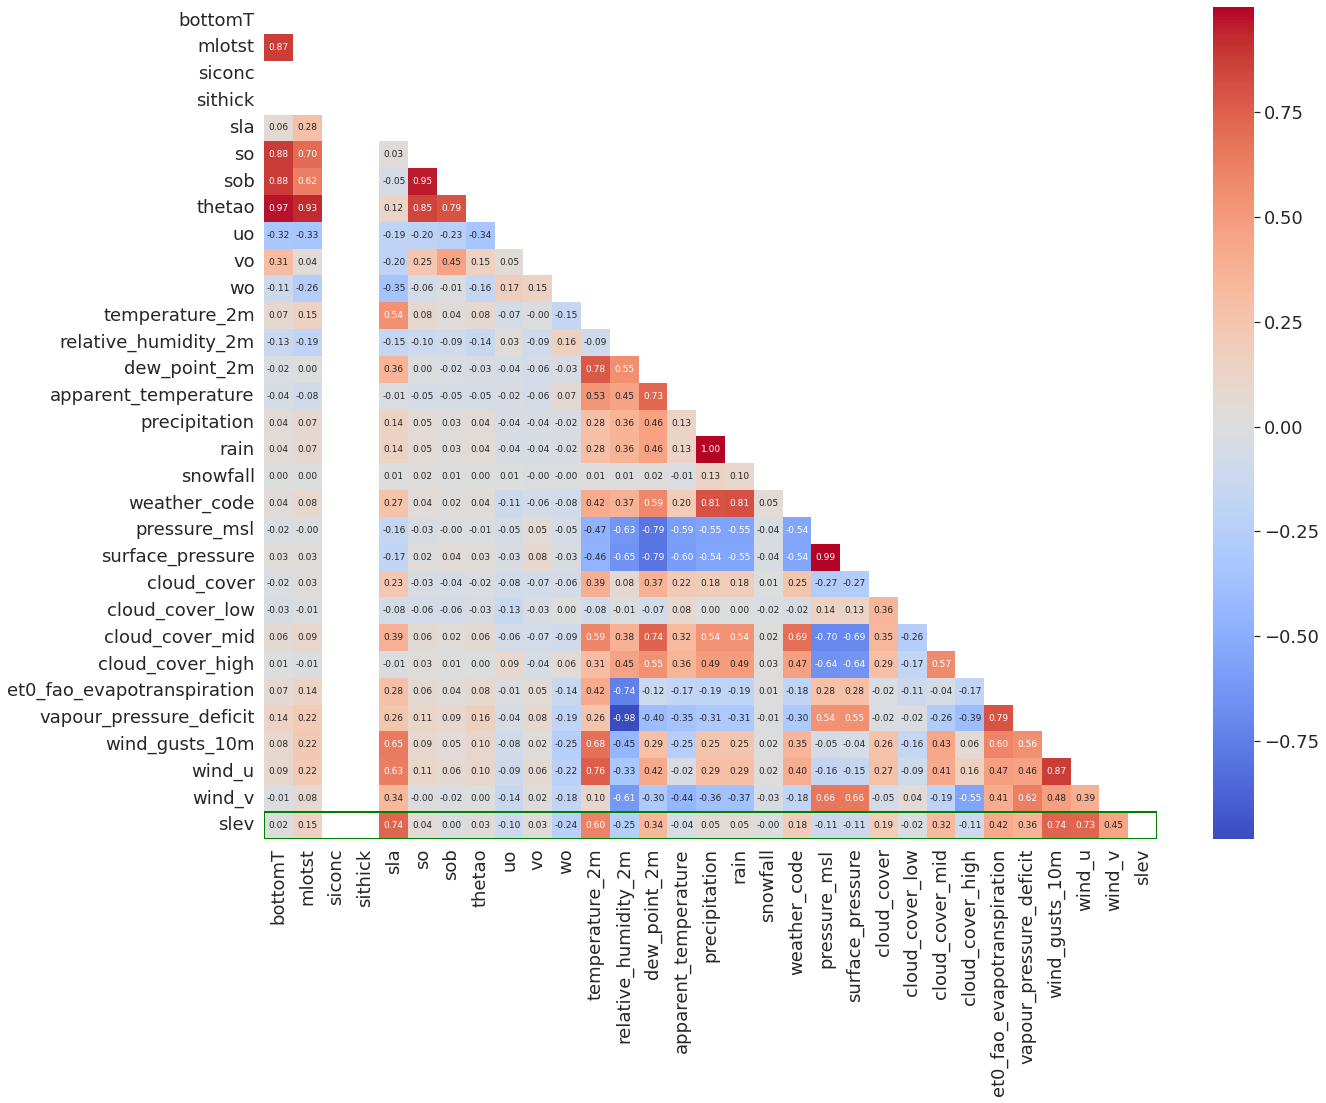

In [17]:
# Definiere den Zeitbereich (3 Tage vor und 3 Tage nach jedem Sturmereignis)
time_ranges = []
for event in sturm_surge_list:
    start_time = event - pd.Timedelta(days=3)
    end_time = event + pd.Timedelta(days=3)
    time_ranges.append((start_time, end_time))

# Filtere die Daten für jeden Zeitbereich und berechne die Korrelation
correlation_matrices = []
for start_time, end_time in time_ranges:
    # Filtere die Daten basierend auf dem Zeitbereich
    filtered_features = df_features[(df_features['time'] >= start_time) & (df_features['time'] <= end_time)]
    filtered_y = df_y[(df_y['time'] >= start_time) & (df_y['time'] <= end_time)]
    
    # Merge die Features und das Ziel (y)
    filtered_df = pd.merge(filtered_features, filtered_y, on='time')
    
    # Entferne unnötige Spalten
    filtered_df = filtered_df.drop(columns=['latitude', 'longitude', 'time'])
    
    # Berechne die Korrelationsmatrix
    correlation_matrix = filtered_df.corr()
    correlation_matrices.append((start_time, end_time, correlation_matrix))

# Plotten der Korrelationsmatrizen
# for i, (start_time, end_time, correlation_matrix) in enumerate(correlation_matrices):
#     plt.figure(figsize=(16, 14))
#     sns.heatmap(correlation_matrix, 
#                 annot=True, 
#                 fmt=".2f", 
#                 cmap="coolwarm", 
#                 cbar=True, 
#                 mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
#                 square=True,
#                 annot_kws={"size": 8}  # Schriftgröße der Annotationen
#                 )
#     plt.title(f"Correlation from {start_time} to {end_time}")
#     plt.show()


import matplotlib.patches as patches

highlight_row = "slev"  # Name der Zeile, die umrahmt werden soll

for i, (start_time, end_time, correlation_matrix) in enumerate(correlation_matrices):
    plt.figure(figsize=(20, 15))
    ax = sns.heatmap(
        correlation_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        cbar=True, 
        mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)),
        square=False,
        annot_kws={"size": 9}
    )

    # Index der slev-Zeile finden
    if highlight_row in correlation_matrix.index:
        row_index = correlation_matrix.index.get_loc(highlight_row)

        # Rechteck hinzufügen (x, y, breite, höhe)
        rect = patches.Rectangle(
            (0, row_index),              # Startpunkt (links, unten)
            len(correlation_matrix.columns),  # Breite (alle Spalten)
            1,                           # Höhe = 1 Zeile
            linewidth=2, 
            edgecolor="green", 
            facecolor="none"
        )
        ax.add_patch(rect)

    #plt.title(f"Correlation from {start_time} to {end_time}")
    plt.savefig(f"../thesis_plots/correlation_map_from_{start_time.strftime('%Y-%m-%d')}_to_{end_time.strftime('%Y-%m-%d')}.png", dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
X

<xarray.Dataset> Size: 3GB
Dimensions:                     (time: 20137, latitude: 25, longitude: 25)
Coordinates:
  * time                        (time) datetime64[ns] 161kB 2022-12-04 ... 20...
  * latitude                    (latitude) float64 200B 53.72 53.99 ... 60.01
  * longitude                   (longitude) float64 200B 9.097 9.676 ... 22.99
Data variables: (12/30)
    bottomT                     (time, latitude, longitude) float64 101MB 0.0...
    mlotst                      (time, latitude, longitude) float64 101MB 0.0...
    siconc                      (time, latitude, longitude) float64 101MB 0.0...
    sithick                     (time, latitude, longitude) float64 101MB 0.0...
    sla                         (time, latitude, longitude) float64 101MB 0.0...
    so                          (time, latitude, longitude) float64 101MB 0.0...
    ...                          ...
    cloud_cover_high            (time, latitude, longitude) float64 101MB 0.0...
    et0_fao_evapotranspiration  (time, latitude, longitude) float64 101MB 0.0...
    vapour_pressure_deficit     (time, latitude, longitude) float64 101MB 0.0...
    wind_gusts_10m              (time, latitude, longitude) float64 101MB 0.0...
    wind_u                      (time, latitude, longitude) float64 101MB 0.0...
    wind_v                      (time, latitude, longitude) float64 101MB 0.0...

In [ ]:
y

<xarray.DataArray 'y' (time: 20137)> Size: 81kB
array([0.34479868, 0.2854355 , 0.21297951, ..., 0.53833336, 0.55      ,
       0.55      ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 161kB 2022-12-04 ... 2025-03-22

Gefundener Zeitpunkt: 2023-10-20T02:00:00.000000000


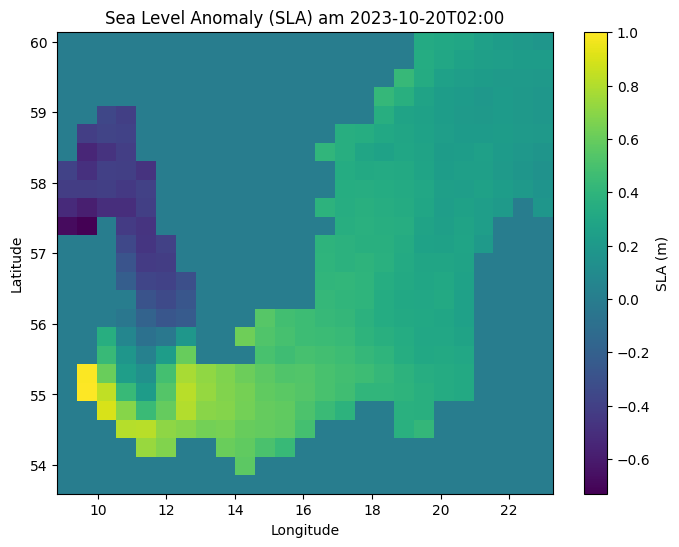

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np



# Zeit als numpy.datetime64
target_time = np.datetime64('2023-10-20T02:00')

# Finde den Index, der am nächsten an diesem Zeitpunkt liegt
nearest_time = X.sel(time=target_time, method='nearest').time.values

print(f"Gefundener Zeitpunkt: {nearest_time}")

# Extrahiere sla zum Zeitpunkt
sla_data = X['sla'].sel(time=nearest_time)

# Setze werte > 1e3 auf NaN
sla_data = sla_data.where(sla_data < 1e3)

# Plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(X['longitude'], X['latitude'], sla_data, shading='auto')
plt.colorbar(label='SLA (m)')
plt.title(f'Sea Level Anomaly (SLA) am {str(np.datetime_as_string(nearest_time, unit="m"))}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
dd

NameError: name 'dd' is not defined

## Test

In [ ]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from utils.dl_helper_functions import (
    load_picture_lagged_data,
)
DTYPE_NUMPY = np.float32  # Set the desired numpy dtype

X, y_lagged, y, common_time = load_picture_lagged_data(
    return_common_time=True,
    verbose=False,
    grid_size=25,
    n_jobs=-1,
    dtype=DTYPE_NUMPY,
    pca=False,
    keep_ocean_data=True,
    eda=False,
    land_values=0.0,  # Set land values to 0.0 for plotting purposes
)

100%|██████████| 20161/20161 [00:06<00:00, 3082.90it/s]


In [ ]:
X.shape, 

((20137, 4, 25, 25),)

X shape: (20137, 4, 25, 25), y shape: (20137,)


Scaling Training features:   0%|          | 0/25 [00:00<?, ?it/s]

Scaling Test features: 100%|██████████| 25/25 [00:03<00:00,  7.94it/s]


Train Shape: torch.Size([16090, 12, 4, 25, 25]), torch.Size([16090, 12])
Test Shape: torch.Size([4023, 12, 4, 25, 25]), torch.Size([4023, 12])
Epoch 1/10, Train Loss: 0.0802
Epoch 2/10, Train Loss: 0.0755
Epoch 3/10, Train Loss: 0.0726
Epoch 4/10, Train Loss: 0.0713
Epoch 5/10, Train Loss: 0.0707
Epoch 6/10, Train Loss: 0.0704
Epoch 7/10, Train Loss: 0.0700
Epoch 8/10, Train Loss: 0.0698
Epoch 9/10, Train Loss: 0.0697
Epoch 10/10, Train Loss: 0.0695


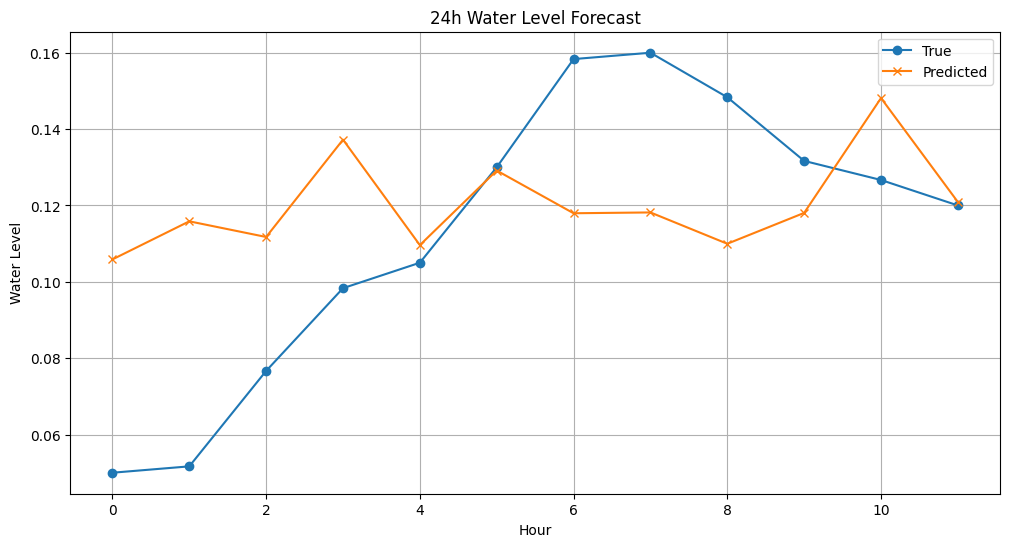

In [ ]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from utils.dl_helper_functions import (
    convert_to_tensors,
    create_sequences,
    load_picture_lagged_data,
    scale_data,
)

# Load and prepare data
X_data = X.copy()  
y_data = y.copy()



print(f"X shape: {X_data.shape}, y shape: {y_data.shape}")
# X shape: (20137, 25, 25, 30), y shape: (20137,)


# Nur gültige Zeitfenster: nehme z. B. 168h Input → 24h Output
window_size = 12
forecast_horizon = 12

X_seq, y_seq = [], []
for i in range(len(X_data) - window_size - forecast_horizon):
    X_seq.append(X_data[i:i+window_size])
    y_seq.append(y_data[i+window_size:i+window_size+forecast_horizon])

X_seq = np.array(X_seq)  # (samples, window, channels, lat, lon)
y_seq = np.array(y_seq)  # (samples, 24)


# Anzahl der Samples
n_samples = len(X_seq)

# z.B. 80% Train, 20% Test
train_size = int(0.8 * n_samples)
test_size = n_samples - train_size

# Aufteilen OHNE Mischen
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_test = X_seq[train_size:]
y_test = y_seq[train_size:]


# scale the data
X_train, _, y_train, _, _, _, X_test, _, y_test, X_scalers, _ = scale_data(
            X_train=X_train, y_lagged_train=None, y_train=y_train,
            X_val=None, y_lagged_val=None, y_val=None,
            X_test=X_test, y_lagged_test=None, y_test=y_test,
            dtype=DTYPE_NUMPY, verbose=True
        )





# Torch Dataset & Split
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"Train Shape: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Test Shape: {X_test_tensor.shape}, {y_test_tensor.shape}")

# TensorDatasets erstellen
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

# CNN + LSTM Model
class CNN_LSTM_Model(nn.Module):
    def __init__(self, in_channels, cnn_out_dim, lstm_hidden_dim, forecast_horizon):
        super(CNN_LSTM_Model, self).__init__()
        # CNN for each time step
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((5, 5)),  # down to 4x4 grid
            nn.Flatten(),  # → (batch, 32*5*5)
        )
        self.cnn_out_dim = 32 * 5 * 5

        # LSTM over time
        self.lstm = nn.LSTM(input_size=self.cnn_out_dim, hidden_size=lstm_hidden_dim, batch_first=True)

        # Fully connected output
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, forecast_horizon)
        )

    def forward(self, x):
        batch_size, seq_len, ch, h, w = x.shape
        x = x.view(-1, ch, h, w)  # merge batch and seq → (batch*seq, ch, h, w)
        cnn_features = self.cnn(x)  # → (batch*seq, cnn_out_dim)
        cnn_features = cnn_features.view(batch_size, seq_len, -1)  # → (batch, seq, cnn_out_dim)
        lstm_out, _ = self.lstm(cnn_features)  # → (batch, seq, lstm_hidden_dim)
        last_hidden = lstm_out[:, -1, :]  # take last time step
        out = self.fc(last_hidden)  # → (batch, forecast_horizon)
        return out

# Model setup
model = CNN_LSTM_Model(
    in_channels=X_train_tensor.shape[2],
    cnn_out_dim=128,
    lstm_hidden_dim=128,
    forecast_horizon=forecast_horizon
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

# -------------------------------
# 3. Training
# -------------------------------
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}")

# -------------------------------
# 4. Testing & Predictions
# -------------------------------
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        predictions.append(outputs.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.vstack(predictions)  # (test_samples, 24)
actuals = np.vstack(actuals)  # (test_samples, 24)




# -------------------------------
# 5. Visualize Predictions
# -------------------------------
idx = 0  # erstes Test-Sample anzeigen
plt.figure(figsize=(12,6))
plt.plot(range(forecast_horizon), actuals[idx], label='True', marker='o')
plt.plot(range(forecast_horizon), predictions[idx], label='Predicted', marker='x')
plt.xlabel('Hour')
plt.ylabel('Water Level')
plt.title('24h Water Level Forecast')
plt.legend()
plt.grid()
plt.show()
